Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. 

In [10]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Colab\ Notebooks/MSDS462/kaggle.json ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d zalando-research/fashionmnist
!ls -l /content
!unzip /content/fashionmnist.zip

 84% 58.0M/68.8M [00:00<00:00, 89.3MB/s]
100% 68.8M/68.8M [00:00<00:00, 108MB/s] 
total 70436
drwx------ 5 root root     4096 Apr  1 20:31 drive
-rw-r--r-- 1 root root 72114846 Apr  1 20:33 fashionmnist.zip
drwxr-xr-x 1 root root     4096 Mar 23 14:22 sample_data
Archive:  /content/fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Functions

In [6]:
def plot_confusion_matrix(conf_mx):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mx, annot=True, fmt='.2f', cbar=False, ax=ax, cmap=plt.cm.gray)
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [38]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")


def subplot_plot_digits(cl_a, cl_b):
  print("0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot \n")
  X_aa = x_test[(y_test == cl_a) & (pred == cl_a)]
  X_ab = x_test[(y_test == cl_a) & (pred == cl_b)]
  X_ba = x_test[(y_test == cl_b) & (pred == cl_a)]
  X_bb = x_test[(y_test == cl_b) & (pred == cl_b)]

  plt.figure(figsize=(8,8))

  p1 = plt.subplot(221)
  p2 = plt.subplot(222)
  p3 = plt.subplot(223)
  p4 = plt.subplot(224)

  plot_digits(X_aa[:25], p1, images_per_row=5);
  plot_digits(X_ab[:25], p2, images_per_row=5);
  plot_digits(X_ba[:25], p3, images_per_row=5);
  plot_digits(X_bb[:25], p4, images_per_row=5);


  p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
  p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
  p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
  p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

  plt.show()

## Load data

In [47]:
#train
train_path = "/content/fashion-mnist_train.csv"
data_train = pd.read_csv(train_path)
num_classes = data_train.shape[0] 
y_train = np.array(data_train.iloc[:, 0])
x_train = np.array(data_train.iloc[:, 1:])
x_train = x_train.reshape(num_classes, 28, 28, 1)

#test
test_path = "/content/fashion-mnist_test.csv"
data_test = pd.read_csv(test_path)
num_classes = data_test.shape[0] 
y_test = np.array(data_test.iloc[:, 0])
x_test = np.array(data_test.iloc[:, 1:])
x_test = x_test.reshape(num_classes, 28, 28, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

## Exploratory data analysis

Labels:
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [49]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [2 9 6 0 3 4 4 5 4 8]



In [50]:
train_freq = Counter(y_train).most_common()
train_freq

[(2, 6000),
 (9, 6000),
 (6, 6000),
 (0, 6000),
 (3, 6000),
 (4, 6000),
 (5, 6000),
 (8, 6000),
 (7, 6000),
 (1, 6000)]

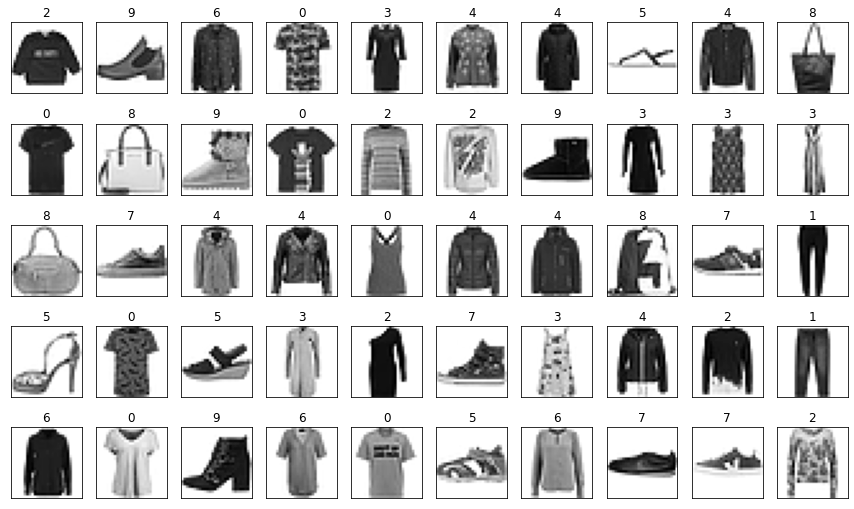

In [51]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

## Preprocess the data

In [52]:
# normalize the images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [53]:
#validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=.1,random_state=42,shuffle=True)

print(x_train.shape, x_val.shape, x_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


## Experiment 1

### Build model

In [55]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))
model.add(layers.Dense(units=10, activation=tf.nn.relu))
model.add(layers.Dense(units=20, activation=tf.nn.relu))
model.add(layers.Dense(10, activation=tf.nn.softmax, name="output_layer")) #10 labels

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
 dense_5 (Dense)             (None, 20)                220       
                                                                 
 output_layer (Dense)        (None, 10)                210       
                                                                 
Total params: 8,280
Trainable params: 8,280
Non-trainable params: 0
_________________________________________________________________


### Compile model

The optimizer used is RMSprop and the loss function is sparse categorical cross entropy (since the labels were not one-hot encoded).

In [57]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [58]:
experiment = "Experiment1"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [59]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6794 - accuracy: 0.7538 - val_loss: 0.5266 - val_accuracy: 0.8070
Epoch 2/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4802 - accuracy: 0.8296 - val_loss: 0.4593 - val_accuracy: 0.8382
Epoch 3/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4439 - accuracy: 0.8430 - val_loss: 0.4319 - val_accuracy: 0.8515
Epoch 4/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4269 - accuracy: 0.8468 - val_loss: 0.4175 - val_accuracy: 0.8515
Epoch 5/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4111 - accuracy: 0.8545 - val_loss: 0.4347 - val_accuracy: 0.8497
Epoch 6/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4024 - accuracy: 0.8555 - val_loss: 0.4089 - val_accuracy: 0.8567
Epoch 7/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3962 - accuracy: 0.8574 - val_loss: 0.4233 - val_accuracy:

### Test model

In [24]:
experiment = "Experiment1"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/Models/'+experiment+'.h5')

In [60]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 2ms/step - loss: 0.4183 - accuracy: 0.8521
test acc: 0.8521000146865845, test loss: 0.41830581426620483


### Plot performance metrics

In [61]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

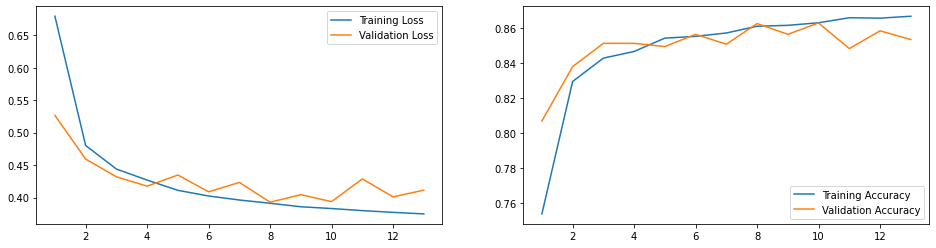

In [63]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

Training and validation graphs are similar but is close to overfitting.

### Confusion matrices

In [64]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [65]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

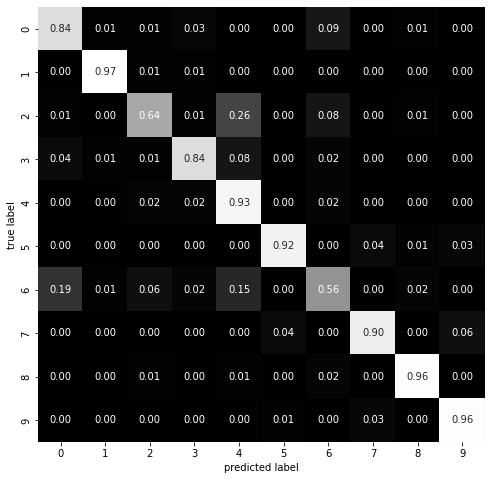

In [66]:
plot_confusion_matrix(norm_conf_mx)

The classification rates are good for each class, ranging from 0.84 to 0.97, except the classes 2 and 6. Class 2 is often mislabeled as 6. Class 6 is often mislabeled as a 4. 

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



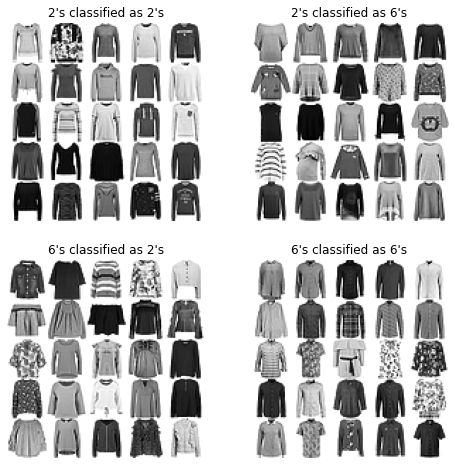

In [68]:
subplot_plot_digits(2,6)

Class 2 and 6 are pullovers and shirts respectively. From the plot, it can be seen that the two types of tops do look very similar to each other, so it makes sense that the model could not easily discriminate between the two. 

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



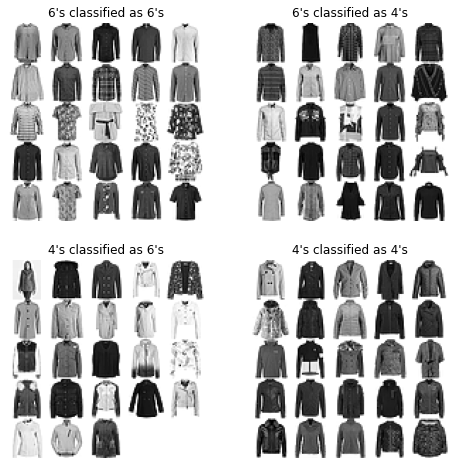

In [69]:
subplot_plot_digits(6,4)

Similarly, Class 6 and 4, shirt and coat respectively, are hard to discriminate even to the human eye.

## Experiment 2

### Build model

In [70]:
model = models.Sequential()

model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1))) 
model.add(layers.MaxPool2D((2, 2), strides=2))

model.add(layers.Flatten())

model.add(layers.Dense(units=20, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 10)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 1690)              0         
                                                                 
 dense_6 (Dense)             (None, 20)                33820     
                                                                 
 output_layer (Dense)        (None, 10)                210       
                                                                 
Total params: 34,130
Trainable params: 34,130
Non-trainable params: 0
__________________________________________________

### Compile model

In [72]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [73]:
experiment = "Experiment2"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [74]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 29s 17ms/step - loss: 0.5685 - accuracy: 0.7978 - val_loss: 0.4214 - val_accuracy: 0.8525
Epoch 2/50
1688/1688 [==============================] - 22s 13ms/step - loss: 0.3953 - accuracy: 0.8590 - val_loss: 0.3891 - val_accuracy: 0.8597
Epoch 3/50
1688/1688 [==============================] - 23s 14ms/step - loss: 0.3493 - accuracy: 0.8773 - val_loss: 0.3373 - val_accuracy: 0.8810
Epoch 4/50
1688/1688 [==============================] - 22s 13ms/step - loss: 0.3182 - accuracy: 0.8879 - val_loss: 0.3098 - val_accuracy: 0.8897
Epoch 5/50
1688/1688 [==============================] - 23s 13ms/step - loss: 0.2959 - accuracy: 0.8956 - val_loss: 0.3059 - val_accuracy: 0.8928
Epoch 6/50
1688/1688 [==============================] - 23s 13ms/step - loss: 0.2795 - accuracy: 0.9021 - val_loss: 0.2947 - val_accuracy: 0.8995
Epoch 7/50
1688/1688 [==============================] - 22s 13ms/step - loss: 0.2654 - accuracy: 0.9067 - val_loss: 0.2906 -

### Test model

In [75]:
experiment = "Experiment2"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/Models/'+experiment+'.h5')

In [76]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 2s 7ms/step - loss: 0.2747 - accuracy: 0.9036
test acc: 0.9035999774932861, test loss: 0.27467694878578186


This model was able to discriminate between the classes more accurately than that of the previous model. It, however, had a longer processing time and more parameters to train. 

### Plot performance metrics

In [77]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

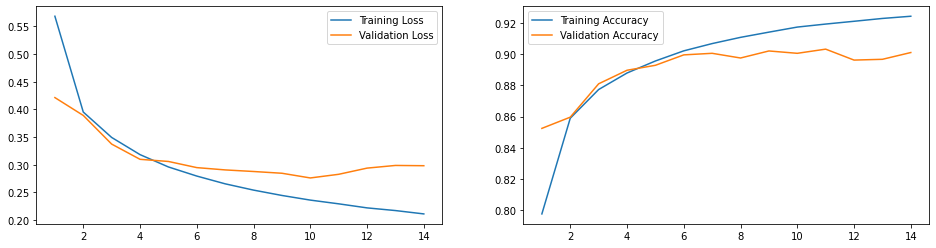

In [79]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The training and validation graphs have a small difference, so there is no overfitting. But if there is more complexity added, there should be some regularization to it. 

### Confusion matrices

In [80]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [81]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

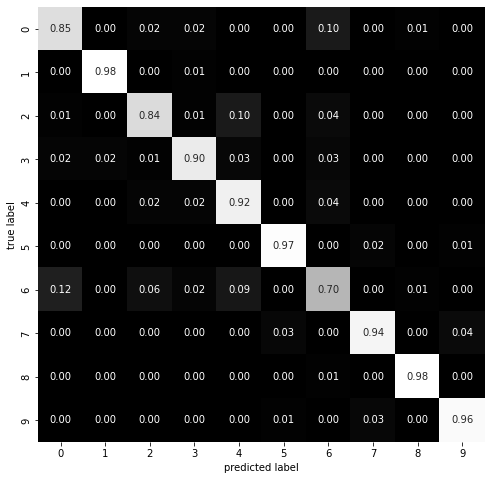

In [82]:
plot_confusion_matrix(norm_conf_mx)

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



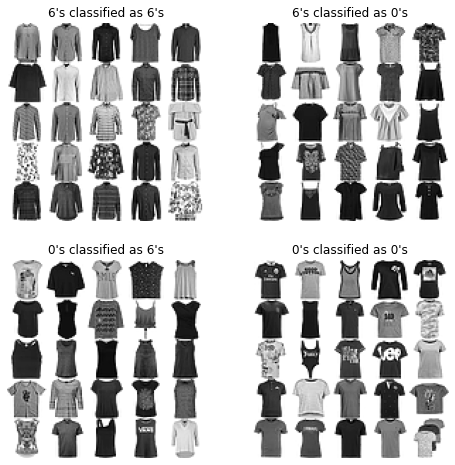

In [84]:
subplot_plot_digits(6,0)

## Experiment 3

### Build model

In [106]:
model = models.Sequential()

model.add(layers.Conv2D(filters=22, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1))) 
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(units=35, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [107]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 22)        220       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 22)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 22)        0         
                                                                 
 flatten_5 (Flatten)         (None, 3718)              0         
                                                                 
 dense_9 (Dense)             (None, 35)                130165    
                                                                 
 output_layer (Dense)        (None, 10)                360       
                                                      

### Compile model

In [108]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [109]:
experiment = "Experiment3"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [110]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 36s 21ms/step - loss: 0.4508 - accuracy: 0.8405 - val_loss: 0.3565 - val_accuracy: 0.8625
Epoch 2/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.3257 - accuracy: 0.8854 - val_loss: 0.2922 - val_accuracy: 0.9012
Epoch 3/50
1688/1688 [==============================] - 36s 21ms/step - loss: 0.2956 - accuracy: 0.8951 - val_loss: 0.2766 - val_accuracy: 0.9027
Epoch 4/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.2771 - accuracy: 0.9019 - val_loss: 0.2659 - val_accuracy: 0.9057
Epoch 5/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.2619 - accuracy: 0.9073 - val_loss: 0.2637 - val_accuracy: 0.9078
Epoch 6/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.2529 - accuracy: 0.9110 - val_loss: 0.2702 - val_accuracy: 0.9055
Epoch 7/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.2446 - accuracy: 0.9128 - val_loss: 0.2717 -

### Test model

In [111]:
experiment = "Experiment3"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/Models/'+experiment+'.h5')

In [112]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 3s 8ms/step - loss: 0.2438 - accuracy: 0.9134
test acc: 0.9133999943733215, test loss: 0.24379616975784302


This model was able to discriminate between the classes more accurately than that of the previous model. It, however, had a longer processing time and more parameters to train. 

### Plot performance metrics

In [113]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

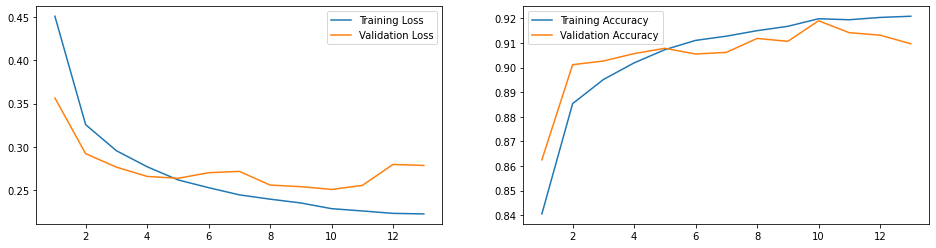

In [115]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The training and validation graphs have a small difference, so there is no overfitting. But if there is more complexity added, there should be some regularization to it. 

### Confusion matrices

In [116]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [117]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

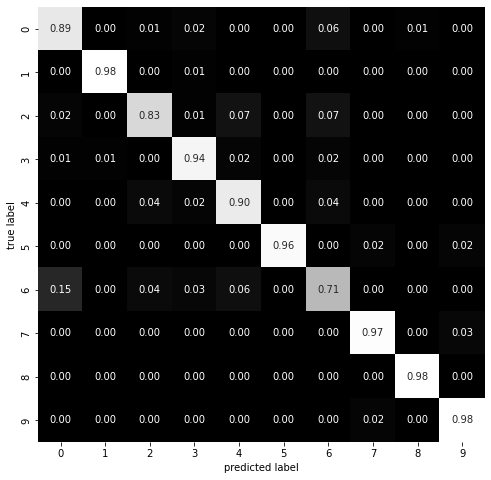

In [118]:
plot_confusion_matrix(norm_conf_mx)

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



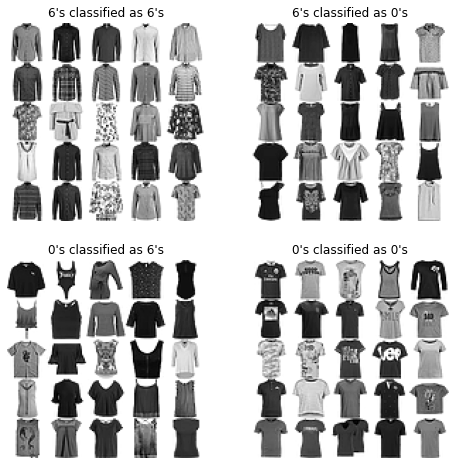

In [119]:
subplot_plot_digits(6,0)

## Experiment 4

### Build model

In [120]:
model = models.Sequential()

model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1))) 
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=22, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu)) 
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(units=35, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [121]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 10)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 10)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 22)        2002      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 22)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 22)         

### Compile model

In [122]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [123]:
experiment = "Experiment4"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [124]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 44s 26ms/step - loss: 0.6634 - accuracy: 0.7552 - val_loss: 0.4702 - val_accuracy: 0.8333
Epoch 2/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.4858 - accuracy: 0.8210 - val_loss: 0.4044 - val_accuracy: 0.8558
Epoch 3/50
1688/1688 [==============================] - 33s 20ms/step - loss: 0.4406 - accuracy: 0.8387 - val_loss: 0.3764 - val_accuracy: 0.8710
Epoch 4/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.4127 - accuracy: 0.8478 - val_loss: 0.3488 - val_accuracy: 0.8760
Epoch 5/50
1688/1688 [==============================] - 35s 21ms/step - loss: 0.3925 - accuracy: 0.8550 - val_loss: 0.3385 - val_accuracy: 0.8833
Epoch 6/50
1688/1688 [==============================] - 34s 20ms/step - loss: 0.3776 - accuracy: 0.8626 - val_loss: 0.3376 - val_accuracy: 0.8822
Epoch 7/50
1688/1688 [==============================] - 36s 22ms/step - loss: 0.3679 - accuracy: 0.8658 - val_loss: 0.3096 -

### Test model

In [125]:
experiment = "Experiment4"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/Models/'+experiment+'.h5')

In [126]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 3s 8ms/step - loss: 0.2823 - accuracy: 0.9003
test acc: 0.9003000259399414, test loss: 0.28227248787879944


This model was able to discriminate between the classes more accurately than that of the previous model. It, however, had a longer processing time and more parameters to train. 

### Plot performance metrics

In [127]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

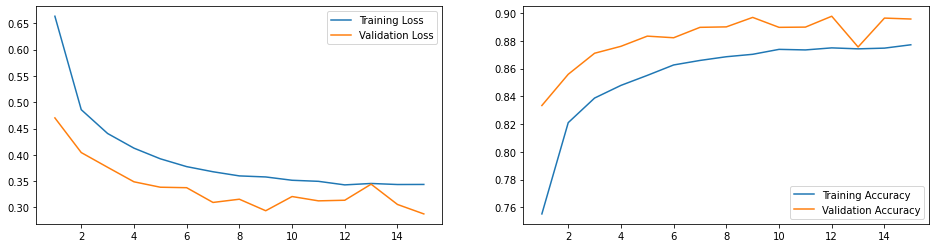

In [129]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

The training and validation graphs have a small difference, so there is no overfitting. But if there is more complexity added, there should be some regularization to it. 

### Confusion matrices

In [130]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [131]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

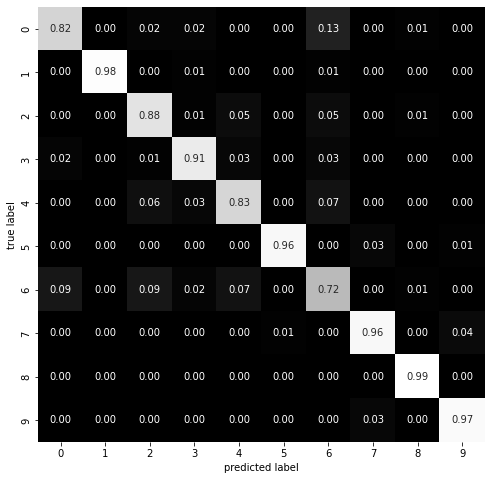

In [132]:
plot_confusion_matrix(norm_conf_mx)

0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot 



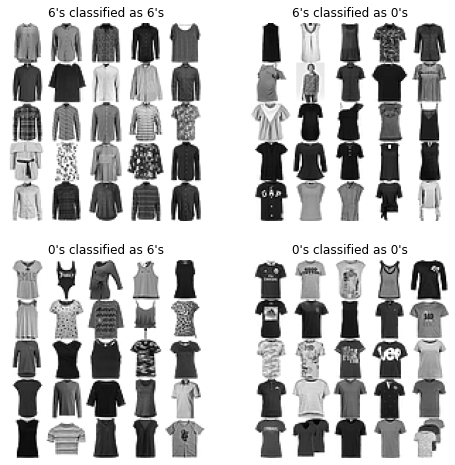

In [133]:
subplot_plot_digits(6,0)

## Experiment 5

### Build model

In [134]:
model = models.Sequential()

model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1)))
model.add(layers.Conv2D(filters=22, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))  
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units=35, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [135]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 22)        2002      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 22)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 12, 12, 22)        0         
                                                                 
 flatten_7 (Flatten)         (None, 3168)              0         
                                                                 
 dense_11 (Dense)            (None, 35)                110915    
                                                      

### Compile model

In [136]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [137]:
experiment = "Experiment5"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [138]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 60s 35ms/step - loss: 0.4763 - accuracy: 0.8279 - val_loss: 0.3377 - val_accuracy: 0.8757
Epoch 2/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.3197 - accuracy: 0.8851 - val_loss: 0.2925 - val_accuracy: 0.8945
Epoch 3/50
1688/1688 [==============================] - 58s 35ms/step - loss: 0.2805 - accuracy: 0.8995 - val_loss: 0.2655 - val_accuracy: 0.9042
Epoch 4/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2582 - accuracy: 0.9078 - val_loss: 0.2520 - val_accuracy: 0.9068
Epoch 5/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2405 - accuracy: 0.9150 - val_loss: 0.2527 - val_accuracy: 0.9112
Epoch 6/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2290 - accuracy: 0.9179 - val_loss: 0.2378 - val_accuracy: 0.9160
Epoch 7/50
1688/1688 [==============================] - 58s 34ms/step - loss: 0.2227 - accuracy: 0.9202 - val_loss: 0.2327 -

### Test model

In [139]:
experiment = "Experiment5"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/Models/'+experiment+'.h5')

In [140]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 4s 11ms/step - loss: 0.2260 - accuracy: 0.9217
test acc: 0.9217000007629395, test loss: 0.22602543234825134


This model was able to discriminate between the classes more accurately than that of the previous model. It, however, had a longer processing time and more parameters to train. 

### Plot performance metrics

In [141]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [142]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

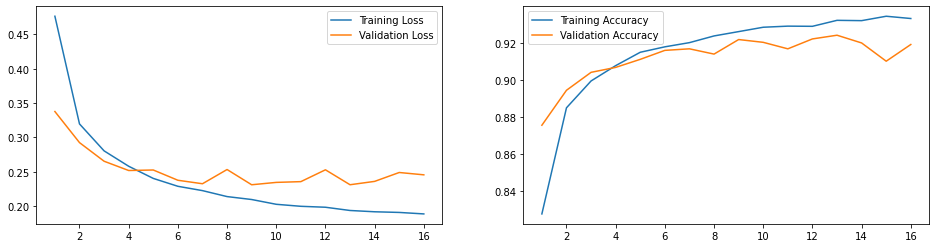

In [143]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion matrices

In [144]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [145]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

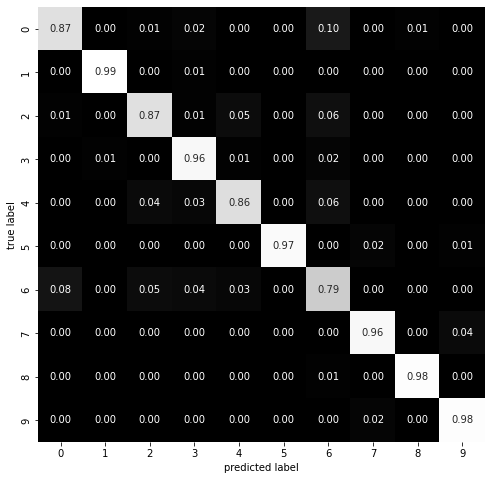

In [146]:
plot_confusion_matrix(norm_conf_mx)

There is better classifiation rates for each class including Class 2 and 6.

## Experiment 6

### Build model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=20, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(28,28,1)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))  
model.add(layers.MaxPool2D((2, 2), strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units=48, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 10)        100       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 22)        2002      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 22)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 12, 12, 22)        0         
                                                                 
 flatten_7 (Flatten)         (None, 3168)              0         
                                                                 
 dense_11 (Dense)            (None, 35)                110915    
                                                      

### Compile model

In [ ]:
model.compile(optimizer='rmsprop',           
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

### Train model

In [ ]:
experiment = "Experiment6"
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)
            ,ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/MSDS462/Models/"+experiment+".h5"
            ,save_best_only=True)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
1688/1688 [==============================] - 60s 35ms/step - loss: 0.4763 - accuracy: 0.8279 - val_loss: 0.3377 - val_accuracy: 0.8757
Epoch 2/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.3197 - accuracy: 0.8851 - val_loss: 0.2925 - val_accuracy: 0.8945
Epoch 3/50
1688/1688 [==============================] - 58s 35ms/step - loss: 0.2805 - accuracy: 0.8995 - val_loss: 0.2655 - val_accuracy: 0.9042
Epoch 4/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2582 - accuracy: 0.9078 - val_loss: 0.2520 - val_accuracy: 0.9068
Epoch 5/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2405 - accuracy: 0.9150 - val_loss: 0.2527 - val_accuracy: 0.9112
Epoch 6/50
1688/1688 [==============================] - 59s 35ms/step - loss: 0.2290 - accuracy: 0.9179 - val_loss: 0.2378 - val_accuracy: 0.9160
Epoch 7/50
1688/1688 [==============================] - 58s 34ms/step - loss: 0.2227 - accuracy: 0.9202 - val_loss: 0.2327 -

### Test model

In [ ]:
experiment = "Experiment6"
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS462/Models/'+experiment+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 4s 11ms/step - loss: 0.2260 - accuracy: 0.9217
test acc: 0.9217000007629395, test loss: 0.22602543234825134


This model was able to discriminate between the classes more accurately than that of the previous model. It, however, had a longer processing time and more parameters to train. 

### Plot performance metrics

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

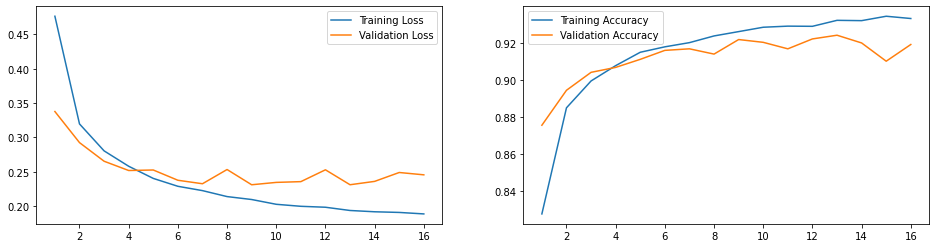

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion matrices

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

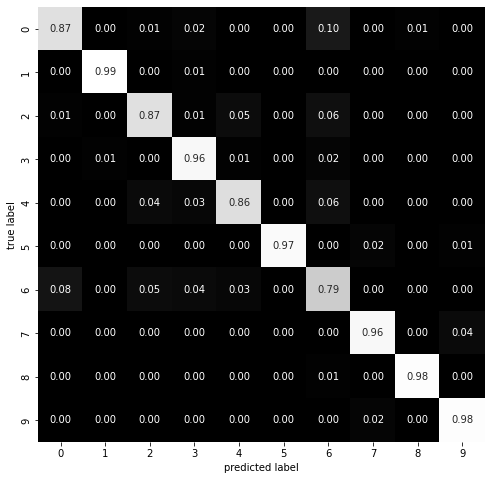

In [ ]:
plot_confusion_matrix(norm_conf_mx)

There is better classifiation rates for each class including Class 2 and 6.